<a href="https://colab.research.google.com/github/ThanakornMix/G1-Consulting-Data-Science/blob/main/Consulting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [77]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
import networkx as nx
from collections import defaultdict
from matplotlib import cm
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
from sklearn.decomposition import LatentDirichletAllocation

### Data Loading

In [78]:
#Data Loading

articles = pd.read_csv('/content/drive/MyDrive/Group 1/articles.CDKN2A.csv')
authors = pd.read_csv('/content/drive/MyDrive/Group 1/authors.CDKN2A.csv')
paper_counts = pd.read_csv('/content/drive/MyDrive/Group 1/paper_counts.csv')

In [79]:
articles.head()

PMID                                              Title  \
0  10551774  Transfection of an inducible p16/CDKN2A constr...   
1  10595918  Malignant transformation of neurofibromas in n...   
2  10620111  Genotype/phenotype and penetrance studies in m...   
3  10630172  The genetics of hereditary melanoma and nevi. ...   
4  10632344  Analysis of oncogene and tumor suppressor gene...   

                                            Abstract       ISSN  \
0  Recent studies have shown that methylation of ...  0888-8809   
1  Patients with neurofibromatosis 1 (NF1) are pr...  0002-9440   
2  Patients with a family history of melanoma are...  0022-202X   
3  Although the first English-language report of ...  0008-543X   
4  Although common among adult intracranial neopl...  1078-0432   

                                             Journal       Location  Year  \
0           Molecular endocrinology (Baltimore, Md.)   (13) 1801-10  1999   
1                  The American journal of pathology  (155) 1879-84  1999   
2           The Journal of investigative dermatology    (114) 28-33  2000   
3                                             Cancer   (86) 2464-77  1999   
4  Clinical cancer research : an official journal...    (5) 4085-90  1999   

  FirstAuthorForename FirstAuthorLastname FirstAuthorInitials  \
0                 S J               Frost                  SJ   
1                 G P             Nielsen                  GP   
2                 J A              Bishop                  JA   
3                 M H              Greene                  MH   
4                   C              Raffel                   C   

                              FirstAuthorAffiliation  
0  Centre for Cell and Molecular Medicine, School...  
1  Molecular Neuro-Oncology Laboratory and the Ja...  
2  ICRF Genetic Epidemiology Laboratory, Leeds, U...  
3  Division of Hematology/Oncology, Mayo Clinic S...  
4  Department of Neurosurgery, Mayo Clinic and Fo...

In [80]:
authors.head()

PMID  AuthorN AuthorForename AuthorLastname AuthorInitials  \
0  10551774        1            S J          Frost             SJ   
1  10551774        2            D J        Simpson             DJ   
2  10551774        3            R N        Clayton             RN   
3  10551774        4            W E        Farrell             WE   
4  10595918        1            G P        Nielsen             GP   

                                   AuthorAffiliation  
0  Centre for Cell and Molecular Medicine, School...  
1                                                NaN  
2                                                NaN  
3                                                NaN  
4  Molecular Neuro-Oncology Laboratory and the Ja...

In [81]:
paper_counts.head()

Year  Count
0  1799      1
1  1801      1
2  1802      1
3  1805      1
4  1866      1

### Data Cleaning

In [82]:
# Data Cleaning: Handle Missing Values and Remove Duplicates
# Handle missing values in `authors_df`
authors['AuthorForename'].fillna('Unknown', inplace=True)
authors['AuthorInitials'].fillna('Unknown', inplace=True)
authors.dropna(subset=['AuthorLastname'], inplace=True)

<ipython-input-82-dcf0bb612f25>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  authors['AuthorForename'].fillna('Unknown', inplace=True)
<ipython-input-82-dcf0bb612f25>:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)',

In [83]:
# Handle missing values in `articles_df`
articles.fillna({
    'Location': 'Unknown',
    'FirstAuthorForename': 'Unknown',
    'FirstAuthorLastname': 'Unknown',
    'FirstAuthorInitials': 'Unknown',
    'FirstAuthorAffiliation': 'Unknown'
}, inplace=True)

In [84]:
# Remove duplicates
articles.drop_duplicates(inplace=True)
authors.drop_duplicates(inplace=True)
paper_counts.drop_duplicates(inplace=True)

In [85]:
#checking for missing values
print(articles.isnull().sum())
print(authors.isnull().sum())
print(paper_counts.isnull().sum())

PMID                      0
Title                     0
Abstract                  0
ISSN                      0
Journal                   0
Location                  0
Year                      0
FirstAuthorForename       0
FirstAuthorLastname       0
FirstAuthorInitials       0
FirstAuthorAffiliation    0
dtype: int64
PMID                     0
AuthorN                  0
AuthorForename           0
AuthorLastname           0
AuthorInitials           0
AuthorAffiliation    13123
dtype: int64
Year     0
Count    0
dtype: int64


In [86]:
# Data Manipulation: Merge and Create Unique Identifiers
# Merge `authors_df` and `articles_df` on `PMID`
merged_df = pd.merge(authors, articles, on='PMID', how='inner')

In [87]:
# Create a unique identifier for researchers
merged_df['ResearcherID'] = merged_df['AuthorLastname'] + '_' + merged_df['AuthorInitials']
merged_df.head()

PMID  AuthorN AuthorForename AuthorLastname AuthorInitials  \
0  10551774        1            S J          Frost             SJ   
1  10551774        2            D J        Simpson             DJ   
2  10551774        3            R N        Clayton             RN   
3  10551774        4            W E        Farrell             WE   
4  10595918        1            G P        Nielsen             GP   

                                   AuthorAffiliation  \
0  Centre for Cell and Molecular Medicine, School...   
1                                                NaN   
2                                                NaN   
3                                                NaN   
4  Molecular Neuro-Oncology Laboratory and the Ja...   

                                               Title  \
0  Transfection of an inducible p16/CDKN2A constr...   
1  Transfection of an inducible p16/CDKN2A constr...   
2  Transfection of an inducible p16/CDKN2A constr...   
3  Transfection of an inducible p16/CDKN2A constr...   
4  Malignant transformation of neurofibromas in n...   

                                            Abstract       ISSN  \
0  Recent studies have shown that methylation of ...  0888-8809   
1  Recent studies have shown that methylation of ...  0888-8809   
2  Recent studies have shown that methylation of ...  0888-8809   
3  Recent studies have shown that methylation of ...  0888-8809   
4  Patients with neurofibromatosis 1 (NF1) are pr...  0002-9440   

                                    Journal       Location  Year  \
0  Molecular endocrinology (Baltimore, Md.)   (13) 1801-10  1999   
1  Molecular endocrinology (Baltimore, Md.)   (13) 1801-10  1999   
2  Molecular endocrinology (Baltimore, Md.)   (13) 1801-10  1999   
3  Molecular endocrinology (Baltimore, Md.)   (13) 1801-10  1999   
4         The American journal of pathology  (155) 1879-84  1999   

  FirstAuthorForename FirstAuthorLastname FirstAuthorInitials  \
0                 S J               Frost                  SJ   
1                 S J               Frost                  SJ   
2                 S J               Frost                  SJ   
3                 S J               Frost                  SJ   
4                 G P             Nielsen                  GP   

                              FirstAuthorAffiliation ResearcherID  
0  Centre for Cell and Molecular Medicine, School...     Frost_SJ  
1  Centre for Cell and Molecular Medicine, School...   Simpson_DJ  
2  Centre for Cell and Molecular Medicine, School...   Clayton_RN  
3  Centre for Cell and Molecular Medicine, School...   Farrell_WE  
4  Molecular Neuro-Oncology Laboratory and the Ja...   Nielsen_GP

### Most active researchers

In [88]:
# Count the number of papers each researcher has been involved in
author_counts = merged_df['ResearcherID'].value_counts().reset_index()
author_counts.columns = ['ResearcherID', 'Count']
# Sort into descending order
author_counts = author_counts.sort_values(by='Count', ascending=False)
most_published_authors = author_counts.head(15)
most_published_authors = pd.DataFrame(most_published_authors)

# Display the dataframe
display(most_published_authors)

ResearcherID  Count
0   Goldstein_AM     62
1         Wang_Y     58
2      Tucker_MA     49
3        Zhang_Y     45
4     Hayward_NK     44
5         Wang_J     41
6      Ghiorzo_P     39
7          Liu_Y     38
8           Li_J     37
9           Li_Y     36
10        Wang_X     35
11       Zhang_J     34
12     Bishop_DT     34
13        Puig_S     34
14     Harland_M     32

### Collaboration Patterns

In [89]:
# create dataframes
df_coauthored = []
df_no_coauthored = []

# get the researcherID of the most published authors
top_15_authors = most_published_authors['ResearcherID'].tolist()

# create pairs of researchers to check if they have collaborated
author_pairs = list(combinations(top_15_authors, 2))

# create a dictionary to store the pair and the papers they've co-authored
coauthored_together = {pair: set() for pair in author_pairs}

# create a collaboration dataframe with columns PMID and ResearcherID
collaboration = merged_df[['PMID', 'ResearcherID']].copy()

# group by PMID and  ResearcherIDs into a list of collaborators
collaboration = collaboration.groupby('PMID')['ResearcherID'].agg(lambda x: ','.join(x)).reset_index()
collaboration.columns = ['PMID', 'Collaborators']

paper_to_collaborators = collaboration.set_index('PMID')['Collaborators'].to_dict()

# for each pair of top 15 authors, check if they have co-authored any paper
for paper_id, collaborators in paper_to_collaborators.items():
    collaborators = collaborators.split(',')
    collaborator_set = set(collaborators)
    # check each pair of top 15 authors
    for author1, author2 in author_pairs:
        # if both authors are in the set of collaborators for this paper, they have co-authored it
        if author1 in collaborator_set and author2 in collaborator_set:
            coauthored_together[(author1, author2)].add(paper_id)

# print out the pairs and the papers they've co-authored
for (author1, author2), papers in coauthored_together.items():
  # if there are co-authored papers then print the authors and papers
  if len(papers) > 0:
    print(f'{author1} and {author2} have co-authored {len(papers)} papers: {papers}')
    # add to the dataframe
    df_coauthored.append({'Author 1': author1,
                          'Author 2': author2,
                          'Co-authored Papers': list(papers)})
  else:
    # if there are no authored papers
    print(f'{author1} and {author2} have not co-authored any papers.')
    # add to the dataframe
    df_no_coauthored.append({'Author 1': author1,
                          'Author 2': author2,
                          'Co-authored Papers': 0})

df_coauthored = pd.DataFrame(df_coauthored)
df_no_coauthored = pd.DataFrame(df_no_coauthored)


Goldstein_AM and Wang_Y have not co-authored any papers.
Goldstein_AM and Tucker_MA have co-authored 49 papers: {10861313, 17047042, 10777219, 18394881, 18803848, 11008905, 21085193, 15856016, 23990928, 23222549, 23384855, 12115352, 12789279, 11828258, 24686846, 29215650, 30731170, 17397031, 36269225, 27449771, 25592620, 15937071, 37585199, 21671477, 11506491, 31326397, 18178632, 16172233, 10738302, 19626699, 19751883, 20876876, 29408205, 16905682, 25239644, 12853981, 12072543, 32283231, 30207590, 14508519, 15173226, 28830827, 23892592, 10869234, 27476724, 20574843, 24762620, 21614589, 12844286}
Goldstein_AM and Zhang_Y have co-authored 1 papers: {33536423}
Goldstein_AM and Hayward_NK have co-authored 12 papers: {18394881, 17047042, 30731170, 21085193, 21983785, 28830827, 20876876, 25592620, 16905682, 23384855, 25077817, 19578364}
Goldstein_AM and Wang_J have co-authored 1 papers: {33536423}
Goldstein_AM and Ghiorzo_P have co-authored 18 papers: {15577313, 17047042, 18394881, 24686846,

In [ ]:
# List of authors who have worked together and the papers they have co-authored
# count the number of co-authored papers
df_coauthored['Number of Co-authored Papers'] = df_coauthored['Co-authored Papers'].apply(len)

df_coauthored

Author 1    Author 2  \
0   Goldstein_AM   Tucker_MA   
1   Goldstein_AM     Zhang_Y   
2   Goldstein_AM  Hayward_NK   
3   Goldstein_AM      Wang_J   
4   Goldstein_AM   Ghiorzo_P   
5   Goldstein_AM       Liu_Y   
6   Goldstein_AM   Bishop_DT   
7   Goldstein_AM      Puig_S   
8   Goldstein_AM   Harland_M   
9         Wang_Y     Zhang_Y   
10        Wang_Y      Wang_J   
11        Wang_Y       Liu_Y   
12        Wang_Y        Li_J   
13        Wang_Y        Li_Y   
14        Wang_Y      Wang_X   
15        Wang_Y     Zhang_J   
16     Tucker_MA  Hayward_NK   
17     Tucker_MA   Ghiorzo_P   
18     Tucker_MA       Liu_Y   
19     Tucker_MA   Bishop_DT   
20     Tucker_MA      Puig_S   
21     Tucker_MA   Harland_M   
22       Zhang_Y      Wang_J   
23       Zhang_Y       Liu_Y   
24       Zhang_Y        Li_J   
25       Zhang_Y        Li_Y   
26       Zhang_Y      Wang_X   
27       Zhang_Y     Zhang_J   
28    Hayward_NK   Ghiorzo_P   
29    Hayward_NK   Bishop_DT   
30    Hayward_NK      Puig_S   
31    Hayward_NK   Harland_M   
32        Wang_J       Liu_Y   
33        Wang_J        Li_J   
34        Wang_J        Li_Y   
35        Wang_J      Wang_X   
36        Wang_J     Zhang_J   
37     Ghiorzo_P       Liu_Y   
38     Ghiorzo_P   Bishop_DT   
39     Ghiorzo_P      Puig_S   
40     Ghiorzo_P   Harland_M   
41         Liu_Y        Li_J   
42         Liu_Y        Li_Y   
43         Liu_Y      Wang_X   
44         Liu_Y     Zhang_J   
45          Li_J        Li_Y   
46          Li_J      Wang_X   
47          Li_Y      Wang_X   
48          Li_Y     Zhang_J   
49        Wang_X     Zhang_J   
50     Bishop_DT      Puig_S   
51     Bishop_DT   Harland_M   
52        Puig_S   Harland_M   

                                   Co-authored Papers  \
0   [10861313, 17047042, 10777219, 18394881, 18803...   
1                                          [33536423]   
2   [18394881, 17047042, 30731170, 21085193, 21983...   
3                                          [33536423]   
4   [15577313, 17047042, 18394881, 24686846, 30731...   
5                                          [24686846]   
6   [18394881, 17047042, 30731170, 21983785, 10738...   
7   [18394881, 17047042, 30731170, 17397031, 21085...   
8   [18394881, 17047042, 30731170, 21085193, 36269...   
9   [24475106, 37068355, 22208613, 28926119, 29037...   
10                     [22510280, 29667179, 23178718]   
11                               [22961080, 37068355]   
12           [24930384, 26139146, 31690770, 27967319]   
13                                         [22961080]   
14                               [24475106, 37068355]   
15                     [37746290, 29667179, 22815924]   
16  [18394881, 17047042, 30731170, 21085193, 28830...   
17  [18394881, 17047042, 24686846, 30731170, 17397...   
18                                         [24686846]   
19  [18394881, 17047042, 30731170, 10738302, 28830...   
20  [18394881, 17047042, 30731170, 17397031, 21085...   
21  [18394881, 17047042, 30731170, 21085193, 36269...   
22                               [26833333, 33536423]   
23                               [37068355, 38091828]   
24                               [30496796, 37674391]   
25           [34358469, 27974690, 27286459, 26833333]   
26                               [24475106, 37068355]   
27                     [33219256, 27974690, 29654170]   
28  [18394881, 17047042, 30731170, 21085193, 28830...   
29  [18394881, 17047042, 24686849, 30731170, 21983...   
30  [18394881, 17047042, 17099875, 30731170, 21085...   
31  [18394881, 17047042, 24686849, 30731170, 21085...   
32           [28272465, 26770338, 31214915, 29755111]   
33                               [34224160, 37770427]   
34                     [24670651, 26833333, 37752791]   
35                                         [28395715]   
36  [26069186, 29667179, 37068173, 21798897, 31700...   
37                                         [24686846]   
38  [18394881, 17047042, 30731170, 28830827, 16905...   

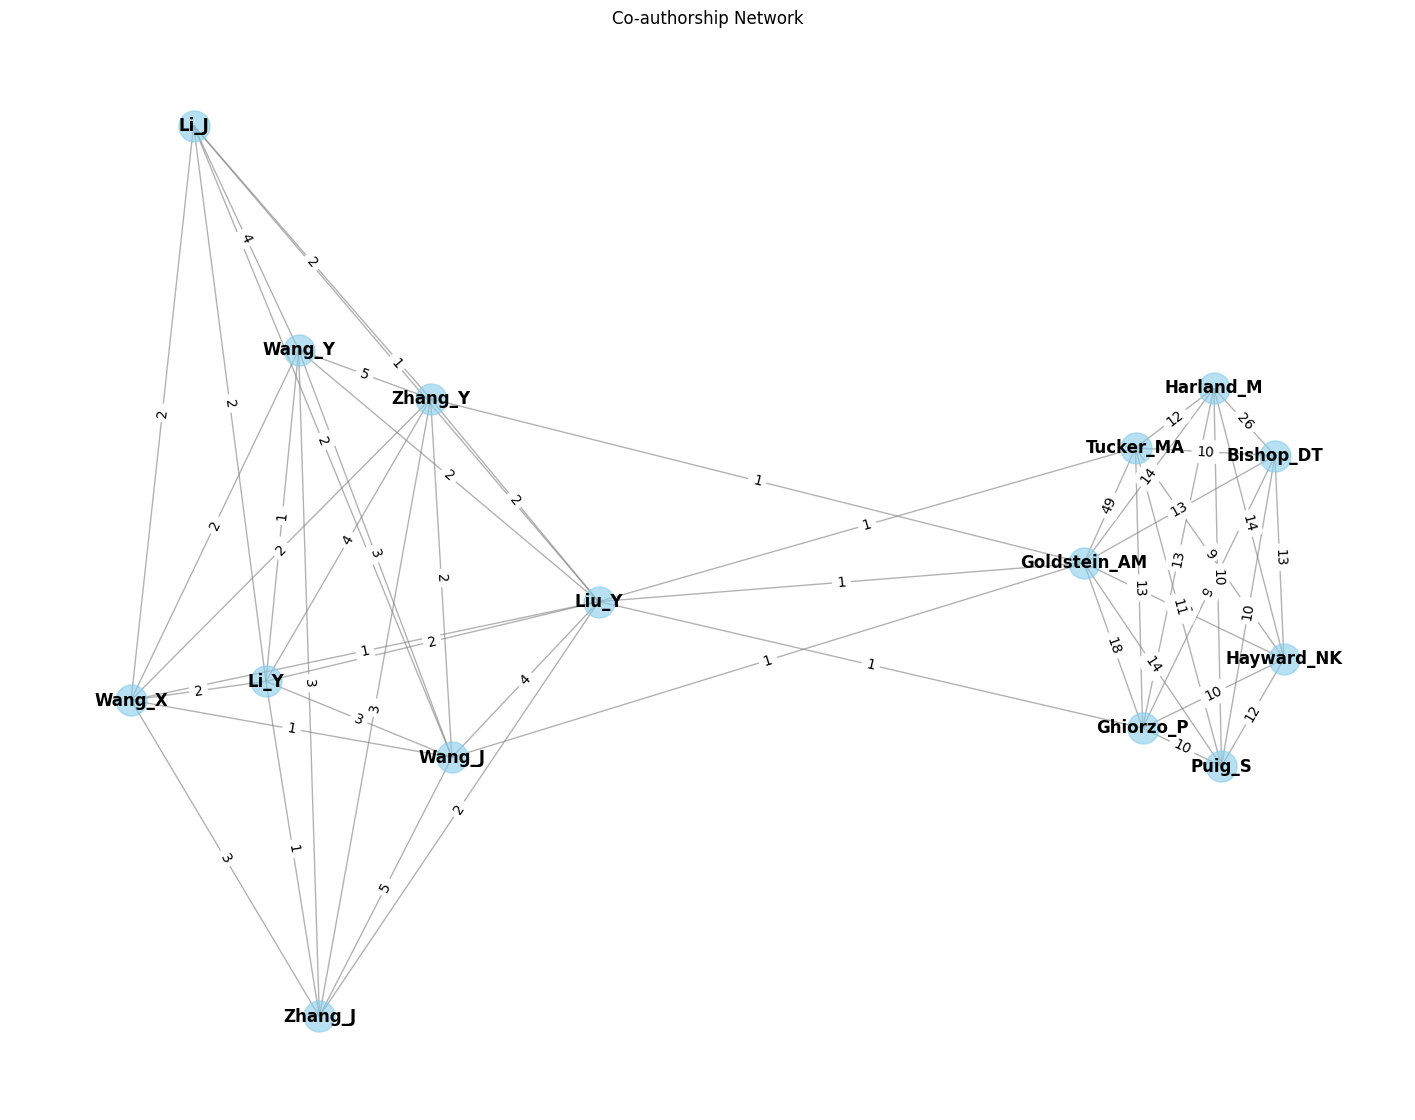

In [90]:
# create a graph
collaboration_network = nx.Graph()

# loop through your dataframe to add lines between researchers
for _, row in df_coauthored.iterrows():
    author1 = row['Author 1']
    author2 = row['Author 2']
    # add number of papers they co-authored
    num_papers = len(row['Co-authored Papers'])

    collaboration_network.add_edge(author1, author2, weight=num_papers)

# draw the network
plt.figure(figsize=(18, 14))
pos = nx.spring_layout(collaboration_network, k=0.5)
nx.draw_networkx_nodes(collaboration_network, pos, node_size=500, node_color="skyblue", alpha=0.6)
nx.draw_networkx_edges(collaboration_network, pos, width=1.0, alpha=0.6, edge_color="gray")
nx.draw_networkx_labels(collaboration_network, pos, font_size=12, font_weight='bold')

edge_labels = nx.get_edge_attributes(collaboration_network, 'weight')
nx.draw_networkx_edge_labels(collaboration_network, pos, edge_labels=edge_labels)

plt.title("Co-authorship Network")
plt.axis("off")
plt.show()


In [ ]:
# The list of authors that has not colloborated with the papers in common
df_no_coauthored

Author 1    Author 2  Co-authored Papers
0   Goldstein_AM      Wang_Y                   0
1   Goldstein_AM        Li_J                   0
2   Goldstein_AM        Li_Y                   0
3   Goldstein_AM      Wang_X                   0
4   Goldstein_AM     Zhang_J                   0
5         Wang_Y   Tucker_MA                   0
6         Wang_Y  Hayward_NK                   0
7         Wang_Y   Ghiorzo_P                   0
8         Wang_Y   Bishop_DT                   0
9         Wang_Y      Puig_S                   0
10        Wang_Y   Harland_M                   0
11     Tucker_MA     Zhang_Y                   0
12     Tucker_MA      Wang_J                   0
13     Tucker_MA        Li_J                   0
14     Tucker_MA        Li_Y                   0
15     Tucker_MA      Wang_X                   0
16     Tucker_MA     Zhang_J                   0
17       Zhang_Y  Hayward_NK                   0
18       Zhang_Y   Ghiorzo_P                   0
19       Zhang_Y   Bishop_DT                   0
20       Zhang_Y      Puig_S                   0
21       Zhang_Y   Harland_M                   0
22    Hayward_NK      Wang_J                   0
23    Hayward_NK       Liu_Y                   0
24    Hayward_NK        Li_J                   0
25    Hayward_NK        Li_Y                   0
26    Hayward_NK      Wang_X                   0
27    Hayward_NK     Zhang_J                   0
28        Wang_J   Ghiorzo_P                   0
29        Wang_J   Bishop_DT                   0
30        Wang_J      Puig_S                   0
31        Wang_J   Harland_M                   0
32     Ghiorzo_P        Li_J                   0
33     Ghiorzo_P        Li_Y                   0
34     Ghiorzo_P      Wang_X                   0
35     Ghiorzo_P     Zhang_J                   0
36         Liu_Y   Bishop_DT                   0
37         Liu_Y      Puig_S                   0
38         Liu_Y   Harland_M                   0
39          Li_J     Zhang_J                   0
40          Li_J   Bishop_DT                   0
41          Li_J      Puig_S                   0
42          Li_J   Harland_M                   0
43          Li_Y   Bishop_DT                   0
44          Li_Y      Puig_S                   0
45          Li_Y   Harland_M                   0
46        Wang_X   Bishop_DT                   0
47        Wang_X      Puig_S                   0
48        Wang_X   Harland_M                   0
49       Zhang_J   Bishop_DT                   0
50       Zhang_J      Puig_S                   0
51       Zhang_J   Harland_M                   0

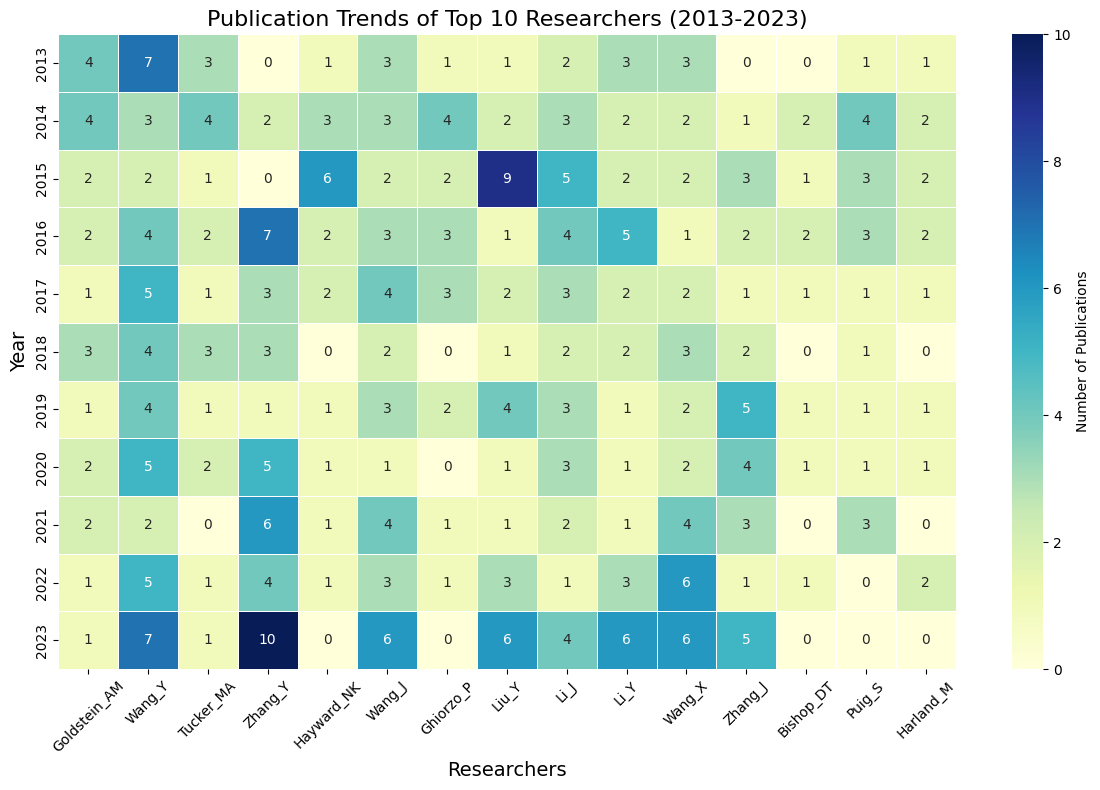

In [91]:
import seaborn as sns
import matplotlib.pyplot as plt

# Count the number of papers each researcher has been involved in
author_counts = merged_df['ResearcherID'].value_counts().reset_index()
author_counts.columns = ['ResearcherID', 'Count']
# Sort into descending order
author_counts = author_counts.sort_values(by='Count', ascending=False)
most_published_authors = author_counts.head(15)

# Extract the top 15 authors
top_15_authors = most_published_authors['ResearcherID'].tolist()

# Further filter data for the years 2014-2024
filtered_data = merged_df[(merged_df['Year'] >= 2013) & (merged_df['Year'] <= 2023)]

# Filter the data to include only the top 15 authors
top_authors_data = filtered_data[filtered_data['ResearcherID'].isin(top_15_authors)]

# Group by Year and ResearcherID, and count publications
yearly_publications = (
    top_authors_data.groupby(['Year', 'ResearcherID'])
    .size()
    .reset_index(name='PublicationCount')
)

# Pivot the data for easier plotting
pivot_data = yearly_publications.pivot(index='Year', columns='ResearcherID', values='PublicationCount').fillna(0)

# Add missing researchers with zero publications for all years in the range
for researcher in top_15_authors:
    if researcher not in pivot_data.columns:
        pivot_data[researcher] = 0

# Re-sort the columns to maintain the order of top 10 authors
pivot_data = pivot_data[top_15_authors]

# Create a heatmap for publication trends
plt.figure(figsize=(12, 8))
heatmap_data = pivot_data

sns.heatmap(
    heatmap_data,
    annot=True,
    fmt="g",
    cmap="YlGnBu",
    linewidths=0.5,
    cbar_kws={"label": "Number of Publications"}
)

# Customizing the plot
plt.title("Publication Trends of Top 10 Researchers (2013-2023)", fontsize=16)
plt.xlabel("Researchers", fontsize=14)
plt.ylabel("Year", fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()

# Show the heatmap
plt.show()


### Topic development over time

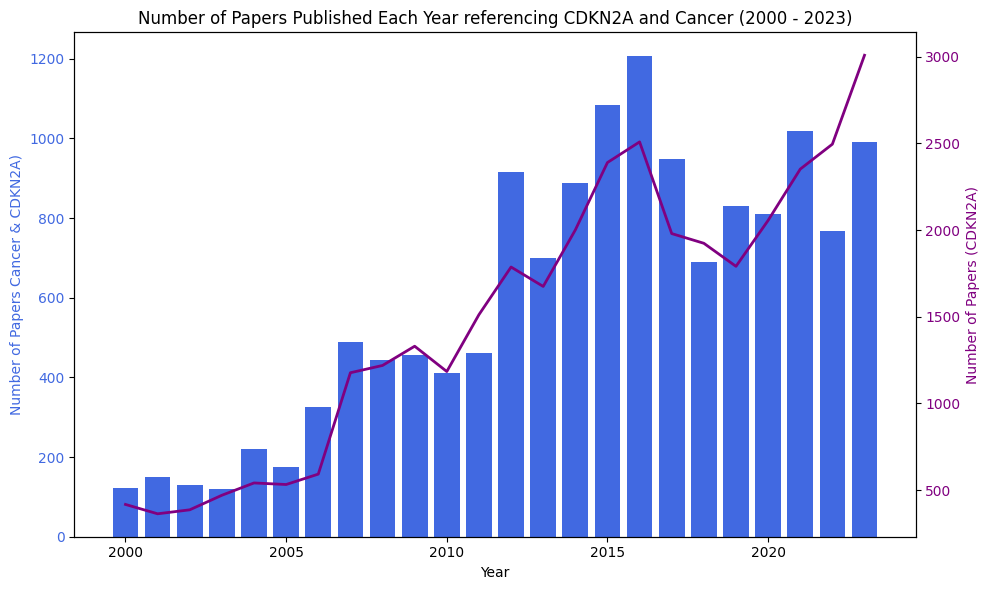

In [92]:
#using the merged_df to count the number of publications per year
filtered_paper_counts = merged_df.groupby('Year').size().reset_index(name = 'Count')
# filter only years 2000 - 2023
filtered_paper_counts = filtered_paper_counts[(filtered_paper_counts['Year'] >= 2000)& (filtered_paper_counts['Year'] <= 2023)]
# count the number of papers per year in the dataframe of cancer related papers
# Filter data for rows where 'Abstract' contains the word 'cancer'
cancer_rows = merged_df[merged_df['Abstract'].str.contains('cancer', case=False, na=False)]
cancer_paper_counts = cancer_rows.groupby('Year').size().reset_index(name='Count')
# filter only years 2000 -2023
cancer_paper_counts = cancer_paper_counts[(cancer_paper_counts['Year'] >= 2000)& (cancer_paper_counts['Year'] <= 2023)]


combined_counts, ax1 = plt.subplots(figsize=(10, 6))
# plot the bar chart for cancer paper counts
ax1.bar(cancer_paper_counts['Year'], cancer_paper_counts['Count'], color='royalblue', label='CDKN2A and Cancer', width=0.8)
ax1.set_xlabel('Year')
ax1.set_ylabel('Number of Papers Cancer & CDKN2A)', color='royalblue')
ax1.tick_params(axis='y', labelcolor='royalblue')

# create a second y-axis for the line chart
ax2 = ax1.twinx()
ax2.plot(filtered_paper_counts['Year'], filtered_paper_counts['Count'], color='purple', label='CDKN2A', linewidth=2)
ax2.set_ylabel('Number of Papers (CDKN2A)', color='purple')
ax2.tick_params(axis='y', labelcolor='purple')

# add the title and show the plot
plt.title('Number of Papers Published Each Year referencing CDKN2A and Cancer (2000 - 2023)')
combined_counts.tight_layout()
plt.show()


In [93]:
top_researchers = merged_df[merged_df['ResearcherID'].isin(top_15_authors)]

# Group by ResearcherID and JournalName, then count publications
researcher_journal_counts = top_researchers.groupby(['ResearcherID', 'Journal'])['PMID'].count().reset_index(name='Count')

# Sort by PublicationCount in descending order
researcher_journal_counts = researcher_journal_counts.sort_values(by=['ResearcherID', 'Count'], ascending=[True, False])

# Get the top journal for each researcher
top_journals_by_researcher = researcher_journal_counts.groupby('ResearcherID').first().reset_index()

top_journals_df = top_journals_by_researcher[['ResearcherID', 'Journal', 'Count']]

print("Top Journals by Publication Count for Top Researchers:")
display(top_journals_df)



Top Journals by Publication Count for Top Researchers:


ResearcherID                                         Journal  Count
0      Bishop_DT                     Genes, chromosomes & cancer      4
1      Ghiorzo_P                               Melanoma research      4
2   Goldstein_AM        The Journal of investigative dermatology      6
3      Harland_M                     Genes, chromosomes & cancer      5
4     Hayward_NK                     Genes, chromosomes & cancer      4
5           Li_J                                      Oncotarget      4
6           Li_Y                                 Nature genetics      3
7          Liu_Y                           Nature communications      3
8         Puig_S  Journal of the American Academy of Dermatology      5
9      Tucker_MA        The Journal of investigative dermatology      6
10        Wang_J                           Nature communications      4
11        Wang_X                                        PloS one      3
12        Wang_Y                                           Blood      2
13       Zhang_J                           Nature communications      5
14       Zhang_Y              American journal of human genetics      2

In [94]:
# Combine author and first author affiliations
cancer_rows['AllAffiliations'] = (
    cancer_rows['AuthorAffiliation'].fillna('') + ' ' + cancer_rows['FirstAuthorAffiliation'].fillna('')
)

# Count publications by institutions
top_institutions = cancer_rows['AllAffiliations'].value_counts().head(10)

top_institutions_df = top_institutions.reset_index()
top_institutions_df.columns = ['Institution', 'PublicationCount']

print("Top Institutions by Publication Count:")
display(top_institutions_df)

Top Institutions by Publication Count:


<ipython-input-94-6e601d68f53a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cancer_rows['AllAffiliations'] = (


Institution  PublicationCount
0   Centre for Cancer Genetic Epidemiology, Depar...               180
1   Epidemiology Research Program, American Cance...               125
2   The Kinghorn Cancer Centre, 370 Victoria Stre...               125
3   Genetic Epidemiology Branch, Division of Canc...                76
4   International Agency for Research on Cancer, ...                65
5                                            Unknown                60
6   Translational Research Laboratories, Universi...                43
7   Université Pierre et Marie Curie-Paris 6, Cen...                39
8   Department of Genetics and Pathology, Interna...                38
9   Cancer Genome Project, Wellcome Trust Sanger ...                35

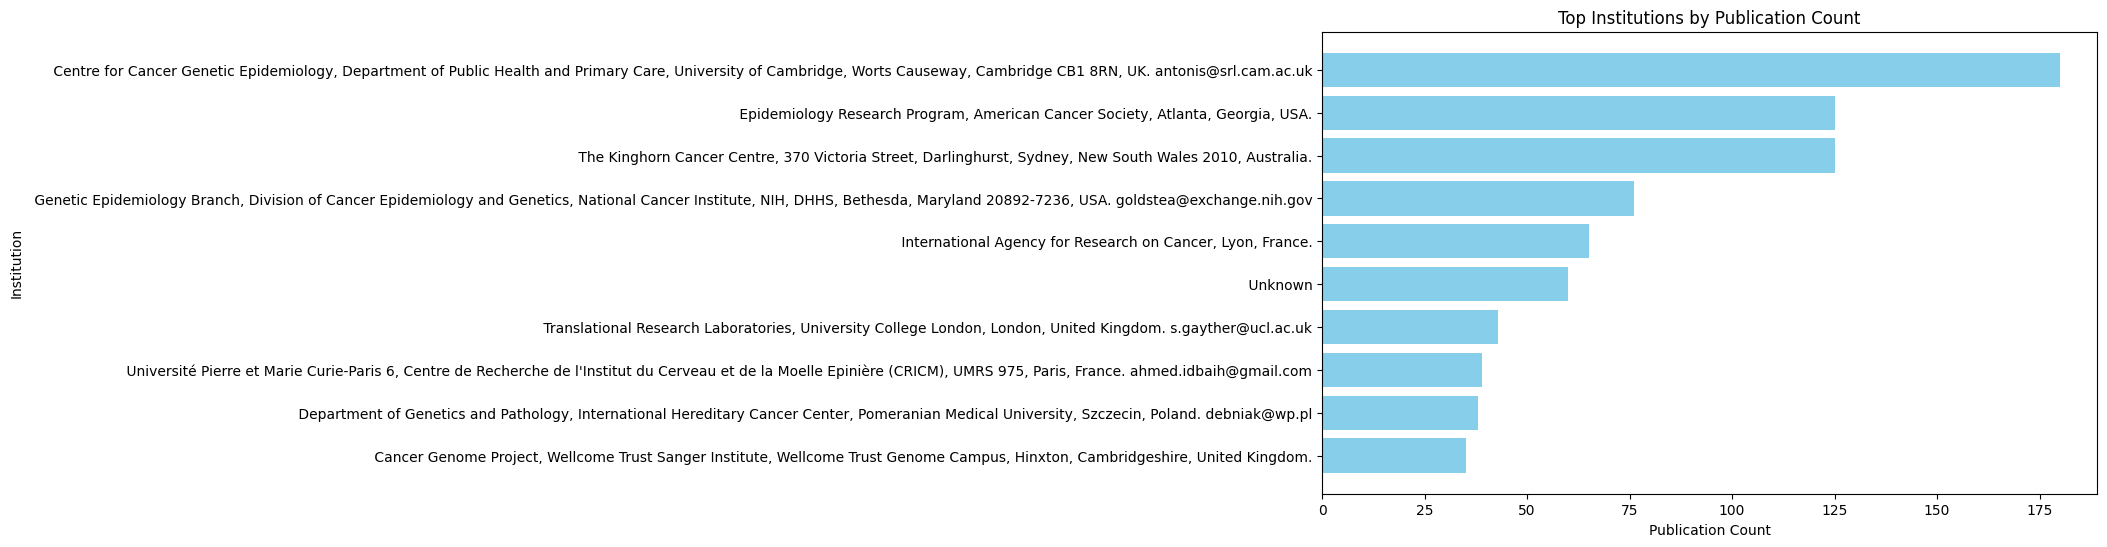

In [75]:
# Plot the bar chart
plt.figure(figsize=(10, 6))
plt.barh(top_institutions_df['Institution'], top_institutions_df['PublicationCount'], color='skyblue')
plt.title('Top Institutions by Publication Count')
plt.xlabel('Publication Count')
plt.ylabel('Institution')

# Display the plot
plt.gca().invert_yaxis()
plt.show()

Number of rows where 'Abstract' contains the word 'cancer': 14370


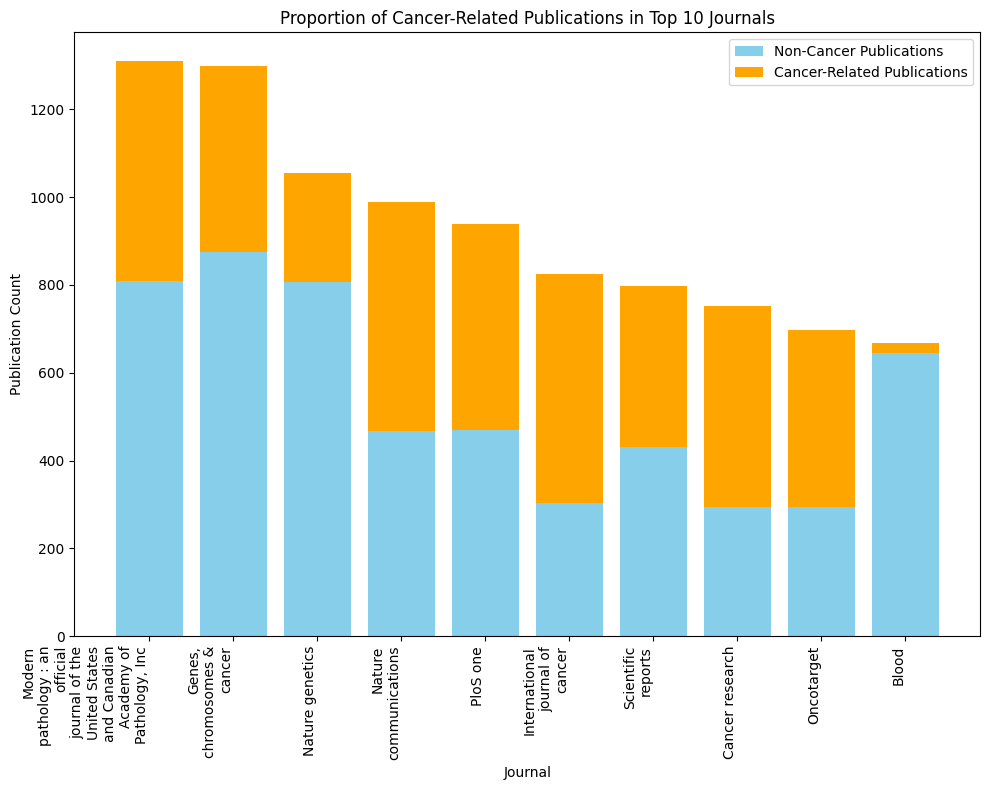

In [95]:
# create a dataframe with only papers which have 'cancer' in their abstracts
cancer_rows = merged_df[merged_df['Abstract'].str.contains('cancer', case=False, na=False)]

# print the number of rows where the abstract contains the word cancer
cancer_count = cancer_rows.shape[0]
print(f"Number of rows where 'Abstract' contains the word 'cancer': {cancer_count}")

# group the original dataframe by 'journal' and count the number of publications
journals = merged_df.groupby('Journal').size().reset_index(name='Count')
# sort by the count in descending order
journals = journals.sort_values(by='Count', ascending=False)


# compare with cancer top journals
# calculate the number of cancer-related publications per journal
cancer_journals = cancer_rows.groupby('Journal').size().reset_index(name='Cancer Publications Count')
cancer_journals = cancer_journals.sort_values(by='Cancer Publications Count', ascending=False)
top_cancer_journals = cancer_journals.head(20)


# Select the top 10 journals for all publications
# The error was here: 'top_journals' was not defined. Changed to 'journals'
top_10_journals = journals.head(10)

# Merge the top 10 most published journals with the cancer journals dataframes
merged_journals = top_10_journals.merge(
    cancer_journals, on='Journal', how='left').fillna(0)



# Extract the journal names, total publication counts and cancer-relatetd publication counts
journals = merged_journals['Journal']
all_counts = merged_journals['Count']
cancer_counts = merged_journals['Cancer Publications Count']
# calculate non cancer-related publications
non_cancer_counts = all_counts - cancer_counts

# create a bar plot showing the total number of publications and cancer publications for the top journals
x = np.arange(len(journals))

fig, ax = plt.subplots(figsize=(10, 8))

# Stacked bars: showing cancer related-publications and non
ax.bar(x, non_cancer_counts, label='Non-Cancer Publications', color='skyblue')
ax.bar(x, cancer_counts, bottom=non_cancer_counts, label='Cancer-Related Publications', color='orange')

# wrap text for long journal names
import textwrap
wrapped_labels = [textwrap.fill(label, width=15) for label in journals]

# add x and y axis labels and a title
ax.set_xlabel('Journal')
ax.set_ylabel('Publication Count')
ax.set_title('Proportion of Cancer-Related Publications in Top 10 Journals')
ax.set_xticks(x)
ax.set_xticklabels(wrapped_labels, rotation=90, ha='right')
ax.legend()

# angle the x axis labels
for tick in ax.get_xticklabels():
    tick.set_rotation(90)

# Show the chart
plt.tight_layout()
plt.show()

<ipython-input-96-40b70ffdc6b7>:23: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


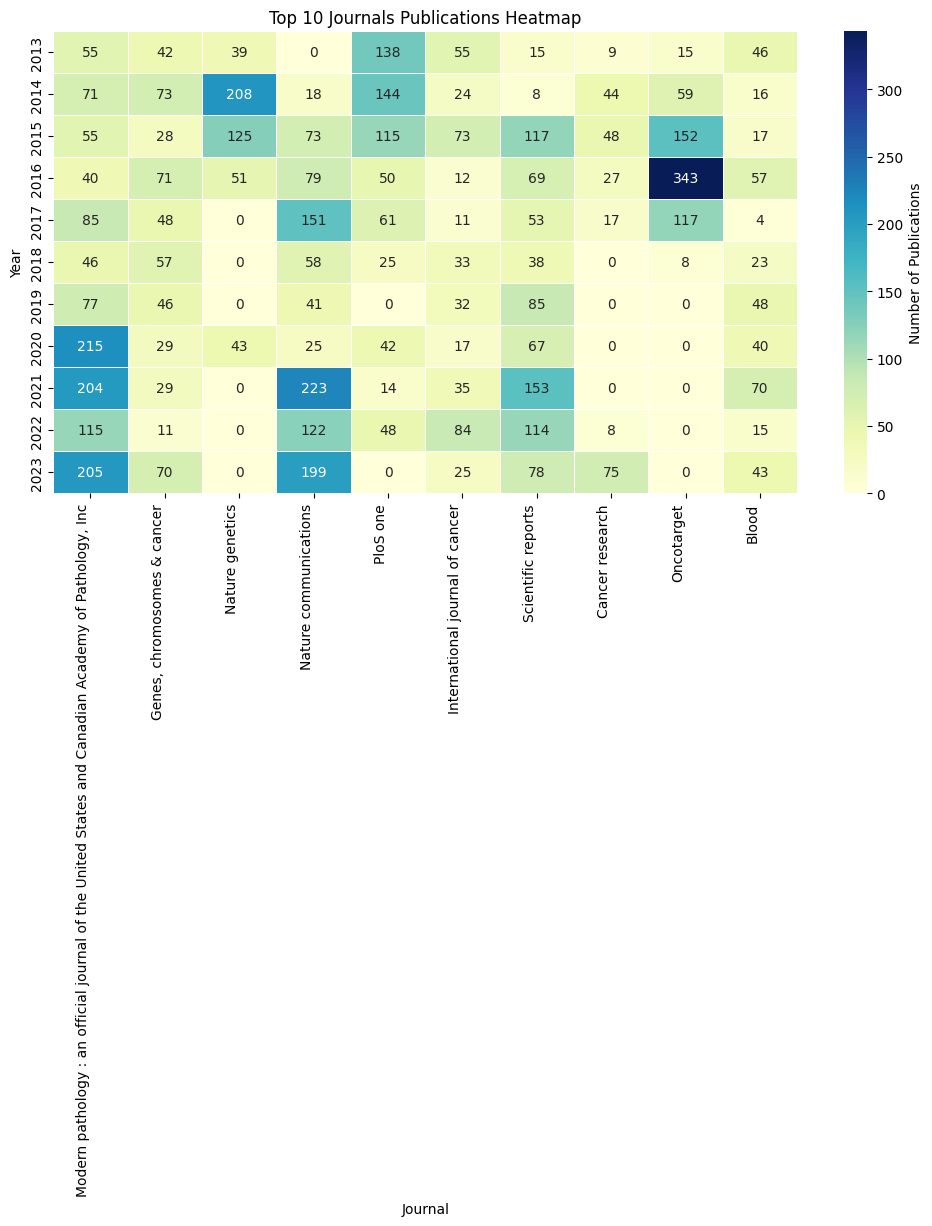

In [96]:
# group the merged dataframe by 'Journal' and 'Year' and count the number of publications for wach
# this gives us the number of publications per journal per year
journal_years = merged_df.groupby(['Journal', 'Year']).size().reset_index(name='Count')
# filter this dataframe to include only the rows where the 'Journal' is in the top 10 most published journals
top_journal_years = journal_years[journal_years['Journal'].isin(top_10_journals['Journal'])]
# futher filter by only including publications from the years 2013 to 2023
top_journal_years = top_journal_years[(top_journal_years['Year'] >= 2013) & (top_journal_years['Year'] <= 2023)]
# pivot the dataframe so that 'Year' becomes the index
pivot_journal_years = top_journal_years.pivot_table(index='Year', columns='Journal', values='Count', aggfunc='sum').fillna(0)

# reorder data to match bar chart
order_journals = top_10_journals['Journal'].tolist()
pivot_journal_years = pivot_journal_years.reindex(columns=order_journals)

# create a heatmap with the pivoted data showing the numbe rof publications per journal per year
plt.figure(figsize=(12, 6))
sns.heatmap(pivot_journal_years, cmap="YlGnBu", annot=True, fmt="g", cbar_kws={'label': 'Number of Publications'}, linewidths=0.5)
# add a title and axis labels to plot
plt.title('Top 10 Journals Publications Heatmap')
plt.xlabel('Journal')
plt.ylabel('Year')
plt.xticks(rotation=90, ha='right')
plt.tight_layout()
plt.show()

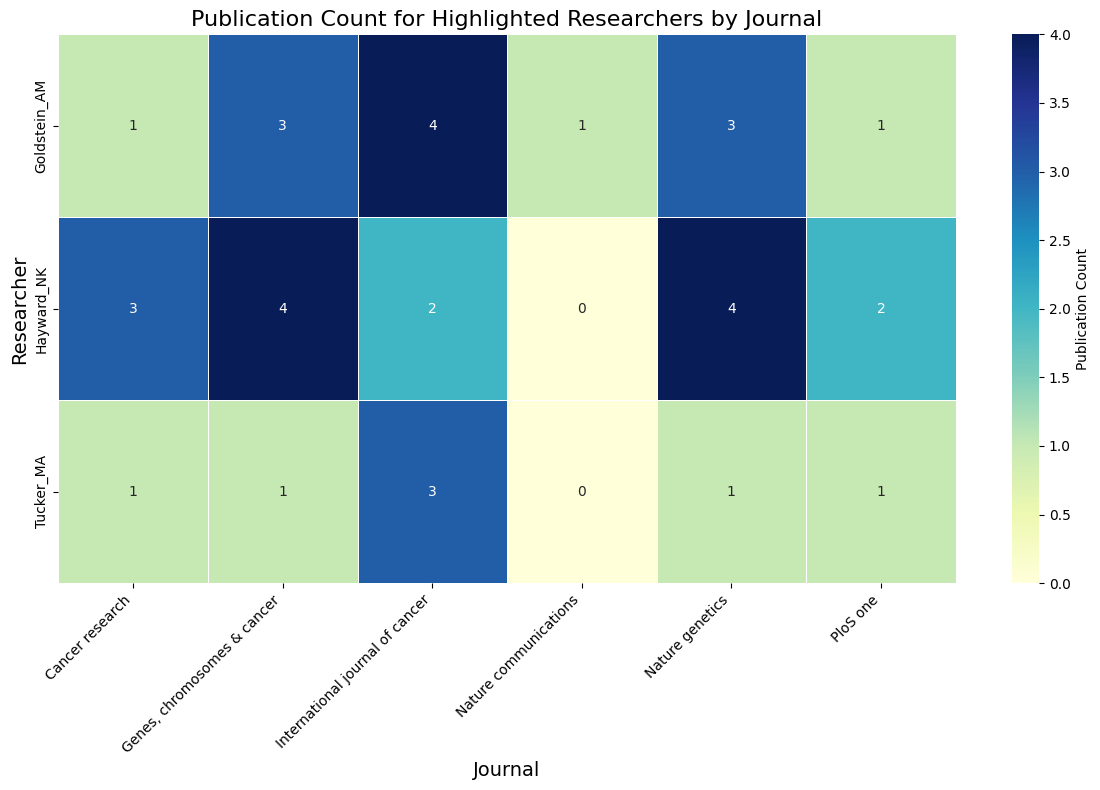

In [97]:
highlighted_researchers = ['Goldstein_AM', 'Tucker_MA', 'Hayward_NK']

author_journal_counts = merged_df.groupby(['ResearcherID', 'Journal']).size().reset_index(name='Publication Count')
author_journal_counts = author_journal_counts.sort_values(by=['ResearcherID', 'Publication Count'], ascending=[True, False])
author_journal_counts = author_journal_counts[author_journal_counts['ResearcherID'].isin(highlighted_researchers)]
filtered_author_journal_counts = author_journal_counts[author_journal_counts['Journal'].isin(top_10_journals['Journal'])]

# Create a pivot table for the heatmap
filtered_author_journal_counts

plt.figure(figsize=(12, 8))
sns.heatmap(
    filtered_author_journal_counts.pivot(index='ResearcherID', columns='Journal', values='Publication Count').fillna(0),
    annot=True,
    fmt="g",
    cmap="YlGnBu",
    linewidths=0.5,
    cbar_kws={"label": "Publication Count"}
)

plt.title('Publication Count for Highlighted Researchers by Journal', fontsize=16)
plt.xlabel('Journal', fontsize=14)
plt.ylabel('Researcher', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [ ]:
journal_keywords = {}

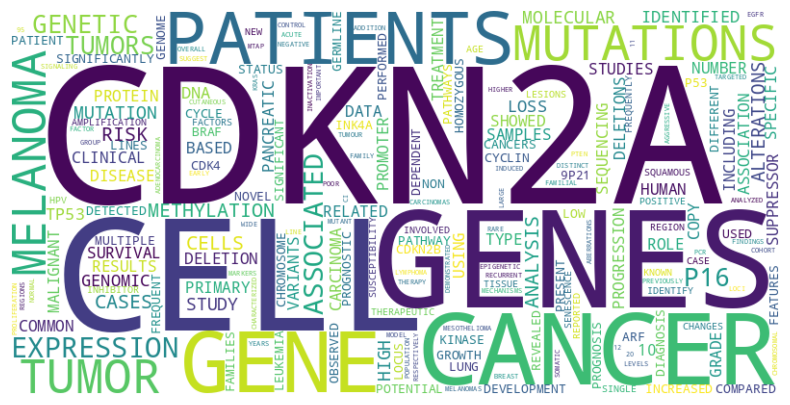

Topic 0: cdkn2a risk p16 associated association

Topic 1: methylation cancer cdkn2a genes dna

Topic 2: mutations cancer patients melanoma cdkn2a

Topic 3: cdkn2a cell alterations tumors patients

Topic 4: cell cdkn2a expression cells melanoma



In [98]:
from gensim import corpora, models
articles['text'] = articles['Title'] + ' ' + articles['Abstract']
# Using CountVectorizer for keyword extraction
vectorizer = CountVectorizer(stop_words='english', max_features=1000)
X = vectorizer.fit_transform(articles['text'])

# Obtain keywords
words = vectorizer.get_feature_names_out()
uppercase_words = [word.upper() for word in words]
# Statistical keyword frequency
word_freq = X.sum(axis=0).A1
word_freq_dict = dict(zip(uppercase_words, word_freq))
# Generate a keyword cloud image.
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq_dict)

# Display keyword cloud diagram.
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

#Using LDA in Scikit-learn for topic modeling.

lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(X)

# Obtain the keywords for each topic
feature_names = vectorizer.get_feature_names_out()
topics = []
for topic_idx, topic in enumerate(lda.components_):
    topic_words = " ".join([feature_names[i] for i in topic.argsort()[:-6:-1]])
    topics.append(f"Topic {topic_idx}: {topic_words}")

# Display the keywords for each topic.
for topic in topics:
    print(topic)
    print()

Journals in heatmap: ['International journal of cancer', 'Genes, chromosomes & cancer', 'Nature genetics', 'Cancer research', 'Nature communications', 'PloS one']


<ipython-input-107-f0f482725d43>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_articles['text'] = filtered_articles['Title'] + ' ' + filtered_articles['Abstract']


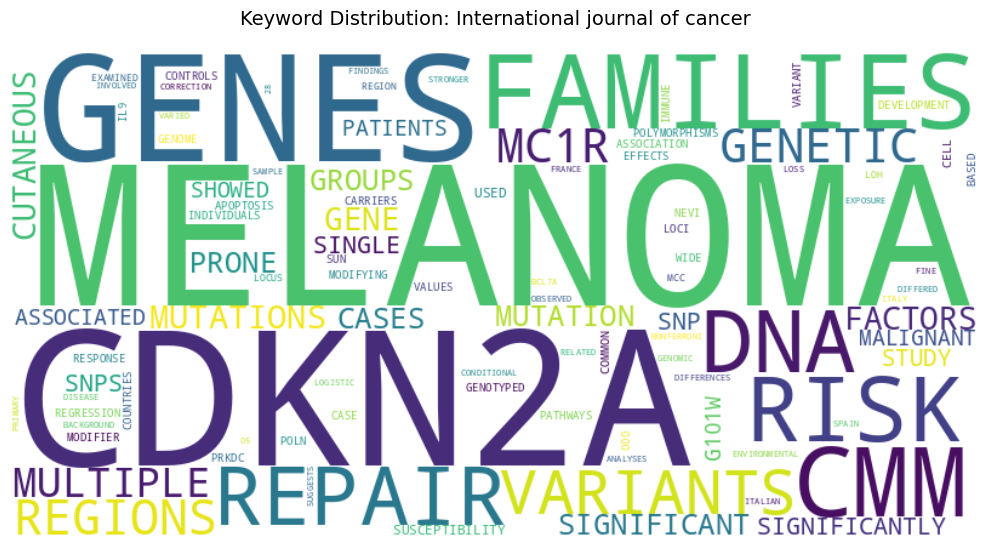

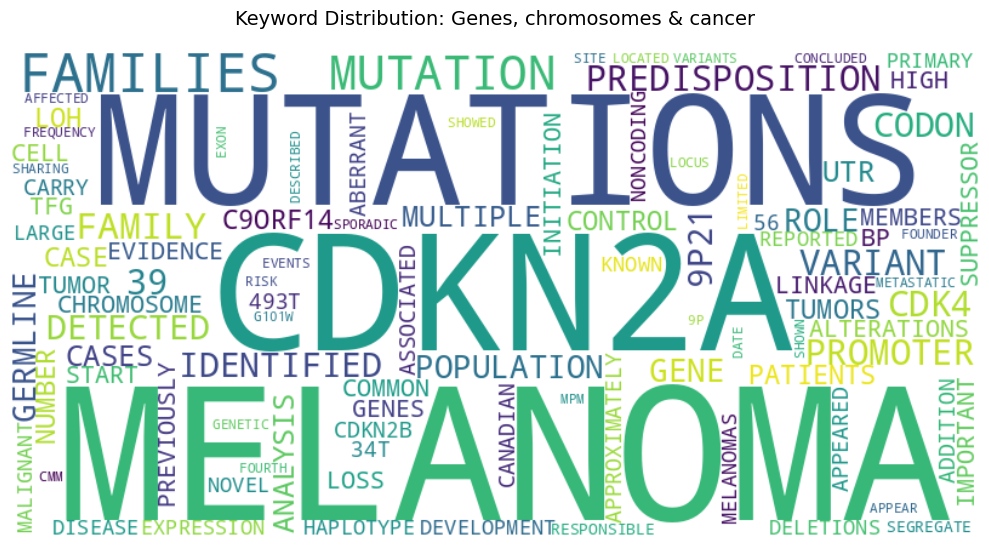

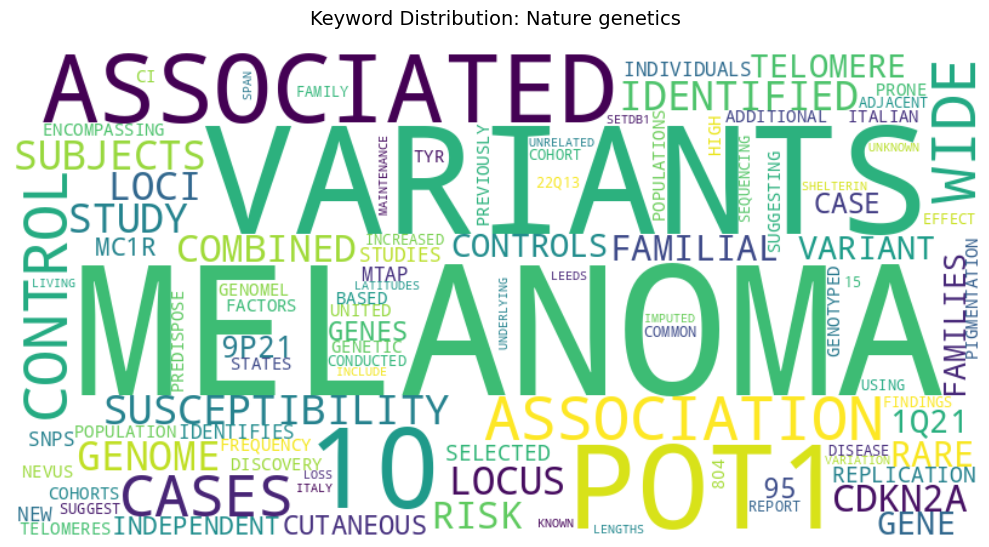

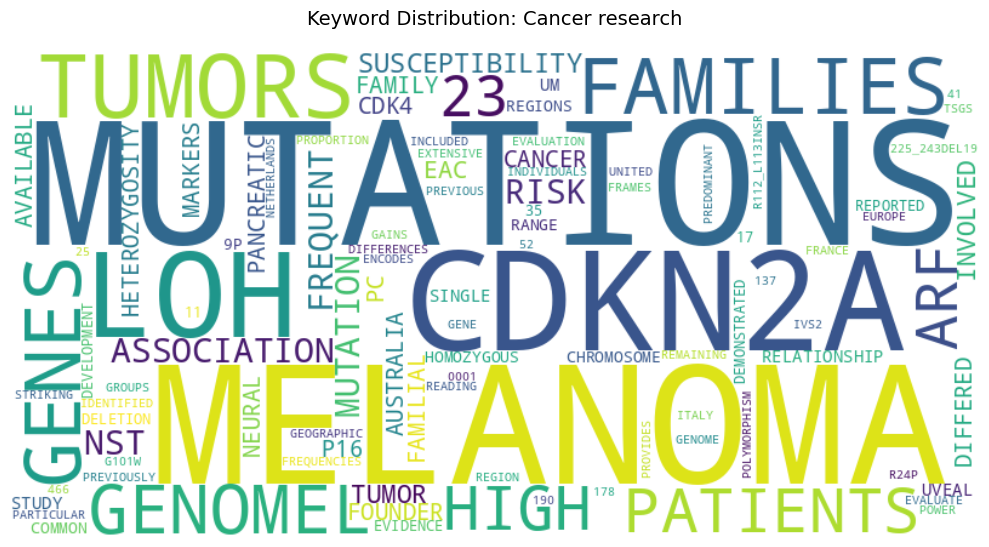

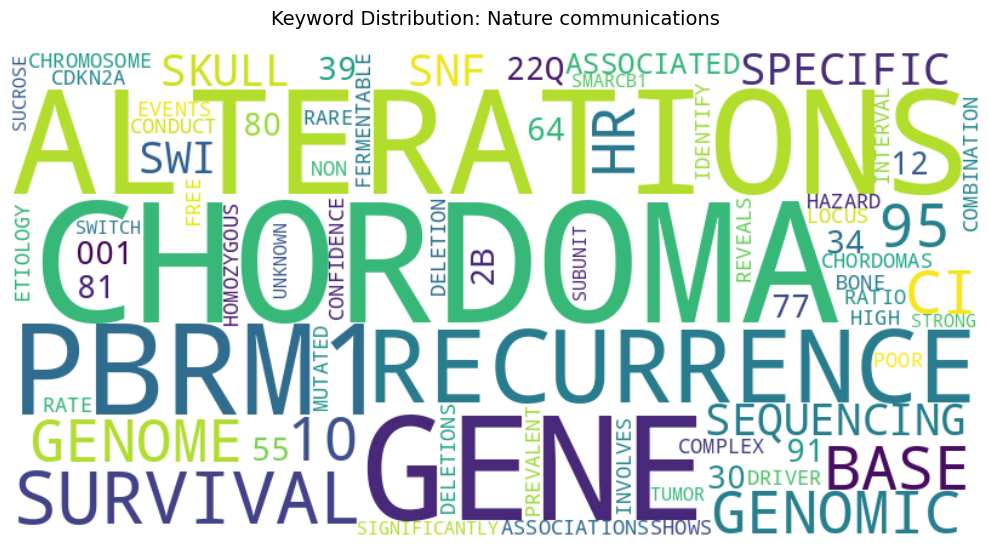

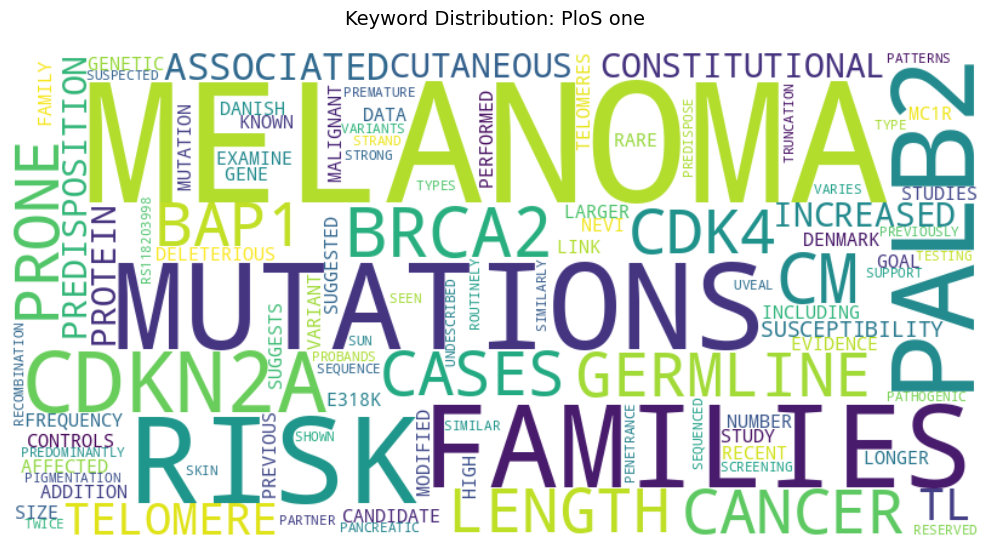

In [107]:
# Get the list of journals actually shown in the heatmap
journals_in_heatmap = filtered_author_journal_counts['Journal'].unique().tolist()
print("Journals in heatmap:", journals_in_heatmap)

# Filter data to include only highlighted researchers and journals in the heatmap
filtered_articles = merged_df[
    (merged_df['ResearcherID'].isin(highlighted_researchers)) &
    (merged_df['Journal'].isin(journals_in_heatmap))
]

# Combine Title and Abstract for text analysis
filtered_articles['text'] = filtered_articles['Title'] + ' ' + filtered_articles['Abstract']

# Generate word cloud for each journal
for journal in journals_in_heatmap:
    # Filter articles for the current journal
    journal_articles = filtered_articles[filtered_articles['Journal'] == journal]

    # Skip if no articles exist
    if journal_articles.empty:
        print(f"No articles found for journal {journal}, skipping.")
        continue

    # Extract and vectorize text
    texts = journal_articles['text'].tolist()
    vectorizer = CountVectorizer(stop_words='english', max_features=100)
    X = vectorizer.fit_transform(texts)

    # Calculate word frequencies
    words = vectorizer.get_feature_names_out()
    uppercase_words = [word.upper() for word in words]
    word_freq = X.sum(axis=0).A1
    word_freq_dict = dict(zip(uppercase_words, word_freq))

    # Generate word cloud
    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color='white',
        collocations=False  # Avoid repeated phrases
    ).generate_from_frequencies(word_freq_dict)

    # Plot word cloud
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Keyword Distribution: {journal}', fontsize=14,pad=20)
    plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, hspace=0.5)
    plt.axis('off')
    plt.tight_layout()
    plt.show()